# High Value Customer Identification (Insiders)

# 0.0 Planejamento da Solução (IOT)

# 0.0 IMPORTS

In [4]:
import re
import os
import pickle
import pandas     as pd
import numpy      as np
import umap.umap_ as umap

from sklearn    import cluster       as c
from sklearn    import metrics       as m
from matplotlib import pyplot        as plt
from sklearn    import preprocessing as pp
from sklearn    import decomposition as dc
from sklearn    import ensemble      as en

from sqlalchemy import create_engine

## 0.2 Load Dataset

In [6]:
#path = '/home/matheus/repos/loyalty-clustering-programm'
path_s3 = 's3://insiders-dataset-mv/'

AWS_ACCESS_KEY_ID = os.getenv("AWS_ACCESS_KEY_ID")
AWS_SECRET_ACCESS_KEY = os.getenv("AWS_SECRET_ACCESS_KEY")

data_raw = pd.read_csv(path_s3 + 'Ecommerce.csv',
                       encoding='iso-8859-1',
                       storage_options={'key': AWS_ACCESS_KEY_ID,
                                        'secret': AWS_SECRET_ACCESS_KEY})

data_raw = data_raw.drop(columns=['Unnamed: 8'])

In [7]:
data_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


# 1.0 DESCRIÇÃO DOS DADOS

In [8]:
df1 = data_raw

## 1.1 Rename columns

In [9]:
# Columns names in snake case
cols_new = ['invoice_no', 'stock_code', 'description', 'quantity', 
            'invoice_date', 'unit_price', 'customer_id', 'country']

# Renaming columns
df1.columns = cols_new

## 1.2 Data dimensions

In [10]:
# Information about shape
print(f'Number of lines: {df1.shape[0]}')
print(f'Number of columns: {df1.shape[1]}')

Number of lines: 541909
Number of columns: 8


## 1.3 Data types

In [11]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4 Check NA

In [12]:
# Sum of null values
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5 Replace NA

In [13]:
# Separating null values for customer id
df_missing = df1.loc[df1['customer_id'].isna(), :]
df_not_missing = df1.loc[~df1['customer_id'].isna(), :]

In [14]:
# Search for corresponding customer ids through invoice number
missing_invoice = df_missing['invoice_no'].drop_duplicates().tolist()
df_not_missing.loc[df_not_missing['invoice_no'].isin(missing_invoice), :]

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country


### Creating Customer ID

In [15]:
# Creating reference
df_backup = pd.DataFrame(df_missing['invoice_no'].drop_duplicates())
df_backup['customer_id'] = np.arange(19000, 19000+len(df_backup),1)

# Merging dataframes
df1 = pd.merge(df1, df_backup, on='invoice_no', how='left')

# Coalesce
df1['customer_id'] = df1['customer_id_x'].combine_first(df1['customer_id_y'])

df1 = df1.drop(columns=['customer_id_x', 'customer_id_y'], axis=1)

df1.isna().sum()

invoice_no         0
stock_code         0
description     1454
quantity           0
invoice_date       0
unit_price         0
country            0
customer_id        0
dtype: int64

## 1.6 Change dtypes

In [16]:
# Changing date time
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format='%d-%b-%y')

# Changing customer id to integer
df1['customer_id'] = df1['customer_id'].astype(int)

# 2.0 FILTRAGEM DAS VARIÁVEIS

In [22]:
df2 = df1.copy()

In [23]:
# unit_price
df2 = df2[df2['unit_price'] > 0.04]

# stock_code
df2 = df2[~df2['stock_code'].isin(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
                                   'DCGSSGIRL', 'PADS', 'B', 'CRUK'])]

# description
df2 = df2.drop(columns='description', axis=1)

# country
df2 = df2[~df2['country'].isin(['European Community', 'Unspecified'])]

# quantity
df2_returns = df2[df2['quantity'] < 0]
df2_purchases = df2[df2['quantity'] >= 0]

# Removing bad users
df2 = df2[~df2['customer_id'].isin([16446])]

# 3.0 FEATURE ENGINEERING

In [24]:
df3 = df2.copy()

## 3.1 Feature Creation

In [25]:
# Creating a dataframe with unique customer ids
df_ref = pd.DataFrame({'customer_id': df3['customer_id']}).drop_duplicates(ignore_index=True)

### 3.1.1 Gross Revenue

In [26]:
# Creating RFM features
# Gross Revenue (quantity * unity price)
df2_purchases['gross_revenue'] = df2_purchases['quantity']*df2_purchases['unit_price']

# Monetary
df_monetary = df2_purchases.loc[:, ['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()

# Merging dataframes
df_ref = pd.merge(df_ref, df_monetary, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
dtype: int64

### 3.1.2 Recency - Day From Last Purchase

In [27]:
# Recency - Last Day Purchase for each customer
df_recency = df2_purchases[['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()

# Calculating number of days since last purchase
df_recency['recency_days'] = (df2_purchases['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency = df_recency[['customer_id', 'recency_days']]

# Merging dataframes
df_ref = pd.merge(df_ref, df_recency, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
dtype: int64

### 3.1.3 Quantity of Purchases

In [28]:
# Number of purchases
# Creating dataframe with number of purchases for each customer
df_freq = df2_purchases[['customer_id',
                         'invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index().rename(columns={'invoice_no':
                                                                                                                       'qty_invoices'})

# Merging dataframes
df_ref = pd.merge(df_ref, df_freq, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qty_invoices     91
dtype: int64

### 3.1.5 Quantity of Items Purchased

In [30]:
# Number of items purchased
# Creating dataframe with number of purchases for each customer
df_freq = df2_purchases[['customer_id',
                         'quantity']].groupby('customer_id').sum().reset_index().rename(columns={'quantity': 'qty_items'})

# Merging dataframes
df_ref = pd.merge(df_ref, df_freq, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qty_invoices     91
qty_products     91
qty_items        91
dtype: int64

### 3.1.8 Frequency

In [33]:
# Aggregating max, min, number of days and number of purchases
df_aux = df2_purchases[['customer_id',
                        'invoice_no',
                        'invoice_date']].drop_duplicates().groupby('customer_id').agg(max_ = ('invoice_date', 'max'),
                                                                                      min_ = ('invoice_date', 'min'),
                                                                                      days_ = ('invoice_date', 
                                                                                               lambda x: ((x.max() - x.min()).days)+1),
                                                                                      buy_ = ('invoice_no', 'count')
                                                                                      ).reset_index()

# Frequency
df_aux['frequency'] = df_aux[['buy_', 'days_']].apply(lambda x: (x['buy_']/x['days_'])
                                                      if x['days_'] != 0 else 0, axis=1)

# Merging
df_ref = pd.merge(df_ref, df_aux[['customer_id', 'frequency']], on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qty_invoices     91
qty_products     91
qty_items        91
avg_ticket       91
frequency        91
dtype: int64

### 3.1.9 Number of Returns

In [34]:
# Number of Returns
df_returns = df2_returns[['customer_id', 'quantity']].groupby('customer_id').sum().reset_index().rename(columns={'quantity': 
                                                                                                                 'qty_returns'})

df_returns['qty_returns'] = df_returns['qty_returns']*-1

# Merging dataframes
df_ref = pd.merge(df_ref, df_returns, on='customer_id', how='left')
df_ref.loc[df_ref['qty_returns'].isna(), 'qty_returns'] = 0
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qty_invoices     91
qty_products     91
qty_items        91
avg_ticket       91
frequency        91
qty_returns       0
dtype: int64

# 4.0 ANÁLISE EXPLORATÓRIA DOS DADOS (EDA)

In [38]:
df4 = df_ref.dropna().copy()

## 4.3 Estudo do Espaço

In [39]:
cols_selected = ['customer_id', 'gross_revenue', 'qty_invoices', 'recency_days', 'qty_items', 'frequency', 'qty_returns']

df43 = df_ref[cols_selected].dropna().copy()

### Encoding

In [40]:
# Encoding features with Min Max Scaler
mm = pp.MinMaxScaler()

df43['gross_revenue'] = np.log1p(df43[['gross_revenue']])

recency_days_scaler = pickle.load(open('../features/recency_days_scaler.pkl', 'rb'))
df43['recency_days'] = recency_days_scaler.transform(df43[['recency_days']])

qty_invoices_scaler = pickle.load(open('../features/qty_invoices_scaler.pkl', 'rb'))
df43['qty_invoices'] = qty_invoices_scaler.transform(df43[['qty_invoices']])

qty_items_scaler = pickle.load(open('../features/qty_items_scaler.pkl', 'rb'))
df43['qty_items'] = qty_items_scaler.transform(df43[['qty_items']])

frequency_scaler = pickle.load(open('../features/frequency_scaler.pkl', 'rb'))
df43['frequency'] = frequency_scaler.transform(df43[['frequency']])

qty_returns_scaler = pickle.load(open('../features/qty_returns_scaler.pkl', 'rb'))
df43['qty_returns'] = qty_returns_scaler.transform(df43[['qty_returns']])

X = df43.copy()

### 4.3.4 Tree-Based Embedding

In [41]:
# Decision Tree doesn't require Scalers
X = df43.drop(columns=['customer_id', 'gross_revenue'], axis=1)

# Defining Gross Revenue as target
y = df43['gross_revenue']

# Model definition
rf_model = pickle.load(open('rf_model.pkl', 'rb'))

# Leafs
df_leaf = pd.DataFrame(rf_model.apply(X))

<AxesSubplot: xlabel='embedding_x', ylabel='embedding_y'>

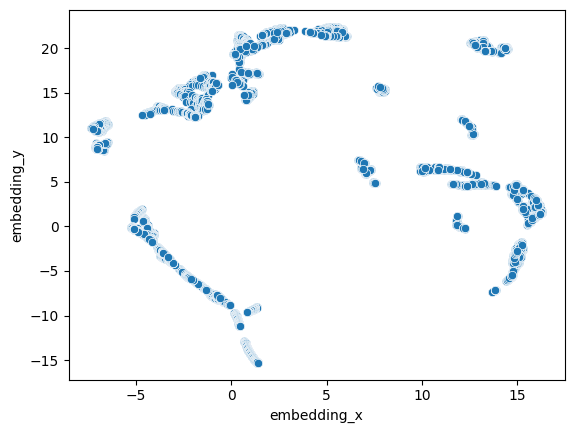

In [42]:
# with UMAP
reducer = pickle.load(open('../features/umap_reducer.pkl', 'rb'))

embedding = reducer.transform(df_leaf)

# Embedding
df_tree = pd.DataFrame()
df_tree['embedding_x'] = embedding[:, 0]
df_tree['embedding_y'] = embedding[:, 1]

# 7.0 HYPERPARAMETER FINE-TUNNING 

In [43]:
# embedded dataset
df7 = df_tree.copy()

# 8.0 MODEL TRAINING

In [44]:
df8 = df7.copy()

## 8.1 K-Means

In [47]:
# Model definition
kmeans = pickle.load(open('kmeans_model.pkl', 'rb'))

# Model training
kmeans.predict(df8)

# Clustering
labels = kmeans.labels_

## 8.2 Cluster Validation

In [48]:
# WSS (Within-Cluster Sum of Squares)
print(f'WSS value: {kmeans.inertia_}')

# SS (Silhouette Score)
print('Silhouette Score: {}'.format(m.silhouette_score(df8, labels, metric='euclidean')))

WSS value: 33372.0703125
Silhouette Score: 0.585281252861023


# 9.0 CLUSTER ANALYSIS

In [49]:
df9 = df_ref[cols_selected].dropna().copy()
df9['cluster'] = labels

,customer_id,gross_revenue,qty_invoices,recency_days,qty_items,frequency,qty_returns,cluster
0,17850,5391.21,34.0,372.0,1733.0,17.000000,40.0,7
1,13047,3232.59,9.0,56.0,1390.0,0.028302,35.0,7
2,12583,6705.38,15.0,2.0,5028.0,0.040323,50.0,2
3,13748,948.25,5.0,95.0,439.0,0.017921,0.0,8
4,15100,876.00,3.0,333.0,80.0,0.073171,22.0,6


# 10.0 DEPLOY TO PRODUCTION

In [ ]:
df10 = df9.copy()

In [ ]:
# Label for each cluster
df10['cluster_name'] = df10['cluster'].apply(lambda x: 'Insiders' if x == 2 
                                                    else 'Leais' if x == 7
                                                    else 'Potenciais' if x == 0
                                                    else 'Novos' if x == 8
                                                    else 'Acompanhar' if x == 3
                                                    else 'Promissor' if x == 5
                                                    else 'Prestes a perder' if x == 6
                                                    else 'Perdendo' if x == 4
                                                    else 'Hibernando')


## 11.1 Insert into Postgres

In [ ]:
# database connection

POSTGRES_PWD = os.getenv("POSTGRES_PWD")

endpoint = 'postgresql://matheus:+' POSTGRES_PWD + '@database-insiders.czzhco95lj75.us-east-1.rds.amazonaws.com:5432/postgres'

engine = create_engine(endpoint)

# Inserting data to database
with engine.connect() as connection:
    df10.to_sql('insiders', con=connection, if_exists='append', index=False)